# A notebook for exploring fuel data
In this notebook, we are looking to discover data values regarding fuel usage that can be obtained from CAN bus.

In [413]:
import binascii
import bitstring
import time
import datetime
import serial
import csv
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

import pandas as pd # Note that this is not commai Panda, but Database Pandas
import cantools 
import matplotlib.animation as animation
from matplotlib import style
import uuid
from strym import strymread
from strym import strymmap

In [414]:
import strym.DBC_Read_Tools as DBC
from datetime import datetime

def dateparse(ts):
    # if you encounter a "year is out of range" error the timestamp
    # may be in milliseconds, try `ts /= 1000` in that case
    ts = float(ts)
    d = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S:%f')
    return d

## The files in question were recorded over three different times
There were four driving tests, from between Points A and B. During each drive, the 

1. Drive as instructed w/ only Techstream connected (Drive from A to B with bursts of fuel to get up to ~40mph and then let off the accelerator pedal)
2. turn the libpanda on, then start up Techstream and record a drive as instructed (Drive from B to A)
3. Drive from A to B but only w/ libpanda
4. Drive from B to A but only w/ libpanda

### Drive 1
Began ~ 13:19 MST on 8/13/2020, ending after approximately 6:38 min:sec.
Drive from Kolb/Sunrise to near Craycroft/Sunrise, West along Sunrise. This drive is recorded *only* by Toyota Techstream

### Drive 2, 2020-08-13-13-26-45_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:28 MST on 8/13/2020, ending after approximately 9:16 min:sec.
From near Craycroft/Sunrise to Kolb/Sunrise, East along Sunrise. This drive also has data recorded from the Toyota Techstream software.

### Drive 3, 2020-08-13-13-38-37_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:38 MST on 8/13/2020, ending after approximately 9:40 min:sec

### Drive 4, 2020-08-13-13-48-16_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:48 MST on 8/13/2020, ending after approximately 6:33 min:sec
From near Craycroft/Sunrise to Kolb/Sunrise, East along Sunrise. This drive also has data recorded from the Toyota Techstream software.



In [415]:
drive3start=1597350406.108452
datetime.fromtimestamp(drive3start)

datetime.datetime(2020, 8, 13, 13, 26, 46, 108452)

In [416]:
pandaDataFolder='/Users/sprinkle/work/data/cyverse/rahulbhadani/JmscslgroupData/PandaData/'
drive2file = pandaDataFolder + '2020_08_13/2020-08-13-13-26-45_2T3Y1RFV8KC014025_CAN_Messages.csv'
drive2file_gps = pandaDataFolder + '2020_08_13/2020-08-13-13-26-45_2T3Y1RFV8KC014025_GPS_Messages.csv'
drive3file = '/Users/sprinkle/work/data/cyverse/rahulbhadani/JmscslgroupData/PandaData/2020_08_13/2020-08-13-13-38-37_2T3Y1RFV8KC014025_CAN_Messages.csv'
#can_data = pd.read_csv(fileName, parse_dates=[0], date_parser=dateparse)# read in the data
can_data_all = pd.read_csv(drive2file)# read in the data

dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile)# Specify your dbc file

In [417]:
# generate maps of our drives from the GPS data
g_drive2 = strymmap(drive2file_gps)

GPS signal first acquired at 2020-08-13 20:26:44:900000

Looking for [chromedriver 84.0.4147.30 mac64] driver in cache 
File found in cache by path [/Users/sprinkle/.wdm/drivers/chromedriver/84.0.4147.30/mac64/chromedriver]


In [357]:
# need the .copy() so that we don't end up with phantom reads that python creates without
# the intelligence of a stdcpp impl that would defer copy to copy-on-write and thus 
# avoid all this documentation nonsense...
can_data = can_data_all[0:-1].copy()

In [358]:
can_data['ClockTime'] = can_data['Time'].apply(dateparse)
can_data

,Time,Bus,MessageID,Message,MessageLength,ClockTime
0,1.597350e+09,2,835,0000430000000091,8.0,2020-08-13 13:26:46:108452
1,1.597350e+09,0,835,0000430000000091,8.0,2020-08-13 13:26:46:108452
2,1.597350e+09,2,705,08ff86ff8cbc009f,8.0,2020-08-13 13:26:46:108452
3,1.597350e+09,0,705,08ff86ff8cbc009f,8.0,2020-08-13 13:26:46:108452
4,1.597350e+09,2,452,0383260838007f38,8.0,2020-08-13 13:26:46:108794
...,...,...,...,...,...,...
2509593,1.597351e+09,1,441,de7ffc00000ffc26,8.0,2020-08-13 13:37:17:848951
2509594,1.597351e+09,1,442,de7ffc00000ffc27,8.0,2020-08-13 13:37:17:849765
2509595,1.597351e+09,2,401,e2ff8830646400fb,8.0,2020-08-13 13:37:17:849765
2509596,1.597351e+09,0,401,e2ff8830646400fb,8.0,2020-08-13 13:37:17:849765


In [385]:
velocity = DBC.convertData('SPEED',1,can_data,db_file)
vel_t = velocity['Time'].values
vel_data = velocity['Message'].values
# find the first velocity value over 40km/hr
# puts the time in the same timeseries through a zip, and returns the 
# first time we are > 40 km/hr
vel_ndx = next( i for i,vel in zip(vel_t,vel_data) if vel > 40 )

%matplotlib widget
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(vel_t,vel_data)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# A second graph that compares speed to RPM for clarity

In [399]:
tmp = DBC.convertData('SPEED',1,can_data,db_file)
starttime0 = tmp['Time'].values[0]
starttime = starttime0+200
can_data_start_ndx = np.where(can_data['Time'] > starttime)[0][0]

velocity = DBC.convertData('SPEED','SPEED',can_data[can_data_start_ndx:],db_file)
rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:],db_file)

%matplotlib widget
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(velocity['Time'],velocity['Message'],'b')
ax.legend(['Speed (km/hr)']) #, 'Gas4' ])
ax = fig.add_subplot(2,1,2)
plt.plot(rpm['Time'],rpm['Message'],'r')
ax.legend(['RPM']) #, 'Gas4' ])



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# A revised pretty plot with some subsets of data

In [412]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
_rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:],db_file)
_gas_released = DBC.convertData('GAS_PEDAL','GAS_RELEASED2',can_data[can_data_start_ndx:],db_file)
_gas_pedal = DBC.convertData('GAS_PEDAL','GAS_PEDAL',can_data[can_data_start_ndx:],db_file)
_gas_0 = DBC.convertData('GAS_PEDAL','PART_0',can_data[can_data_start_ndx:],db_file)
_gas_1 = DBC.convertData('GAS_PEDAL','PART_1',can_data[can_data_start_ndx:],db_file)
_gas_2 = DBC.convertData('GAS_PEDAL','PART_2',can_data[can_data_start_ndx:],db_file)
_gas_N = DBC.convertData('GAS_PEDAL','PART_N',can_data[can_data_start_ndx:],db_file)
#_gas_4 = DBC.convertData('GAS_PEDAL','PART_4',can_data[can_data_start_ndx:can_data_end_ndx],db_file)

fig =plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
plt.title('Gas Pedal CAN code')
# plt.plot(_speed['Time'],_speed['Message'])
# plt.plot(_gas_released['Time'],50*_gas_released['Message'])
plt.plot(_gas_pedal['Time'],_gas_pedal['Message'],'b')
ax = fig.add_subplot(2,1,2)
plt.plot(_gas_0['Time'],0.01*_gas_0['Message'],'r')
# plt.plot(_gas_1['Time'],_gas_1['Message'])
# plt.plot(_gas_2['Time'],_gas_2['Message'])
# plt.plot(_gas_N['Time'],_gas_N['Message'])
# plt.plot(_rpm['Time'],0.01*_rpm['Message'])

# ,
#         _gas_4['Time'],50+10*_gas_4['Message'])
# ax.legend(['Gas Pedal Released (x50)', 'Gas Pedal (%)', 'Gas0', 'Gas1', 'Gas2' ]) #, 'Gas4' ])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# New drives from 8/17/2020

In [433]:
%matplotlib widget
can_data_start_ndx=0
datafolder = "/Users/sprinkle/work/data/cyverse/rahulbhadani/JmscslgroupData/PandaData/2020_08_17/"
drive1filename=datafolder + "2020-08-17-15-35-31_2T3Y1RFV8KC014025_CAN_Messages.csv"
drive2filename=datafolder + "2020-08-17-15-43-47_2T3Y1RFV8KC014025_CAN_Messages.csv"

can_data=pd.read_csv(drive1filename)# read in the data
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
_rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:],db_file)
_gas_pedal = DBC.convertData('GAS_PEDAL','GAS_PEDAL',can_data[can_data_start_ndx:],db_file)
_gas_0 = DBC.convertData('GAS_PEDAL','PART_0',can_data[can_data_start_ndx:],db_file)




fig =plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(_rpm['Time'],0.01*_rpm['Message'],'r')



fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
plt.title('Gas Pedal CAN code')
# plt.plot(_speed['Time'],_speed['Message'])
# plt.plot(_gas_released['Time'],50*_gas_released['Message'])
plt.plot(_gas_pedal['Time'],_gas_pedal['Message'],'b')
# ax = fig.add_subplot(2,1,2)
plt.plot(_gas_0['Time'],0.01*_gas_0['Message'],'r')





Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [382]:
velocity = DBC.convertData('SPEED',1,can_data,db_file)
vel_t = velocity['Time'].values
vel_data = velocity['Message'].values
# find the first velocity value over 40km/hr
# puts the time in the same timeseries through a zip, and returns the 
# first time we are > 40 km/hr
vel_ndx = next( i for i,vel in zip(vel_t,vel_data) if vel > 40 )



# this is the first element of the array where our velocity is over 40 km/hr
i = np.where(vel_data > 40)[0][0]
i

24980

In [384]:
%matplotlib widget
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(vel_t[i:-1],vel_data[i:-1])
#ndx = next ( index(tim) for tim in velocity['Time'].values if velocity['Message'].values[tim] == vel_val )
#ndx

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [361]:
# this is the first element of the array where our velocity is really small
ii = i + np.where(vel_data[i:] <= 0.01)[0][0]
ii

29740

In [362]:
# now find the next time where it is >5 and start plotting again
iii = ii + np.where(vel_data[ii:] > 5 )[0][0]
drive3start=iii
print(f'The first index is {iii}')


The first index is 37386


<IPython.core.display.Javascript object>


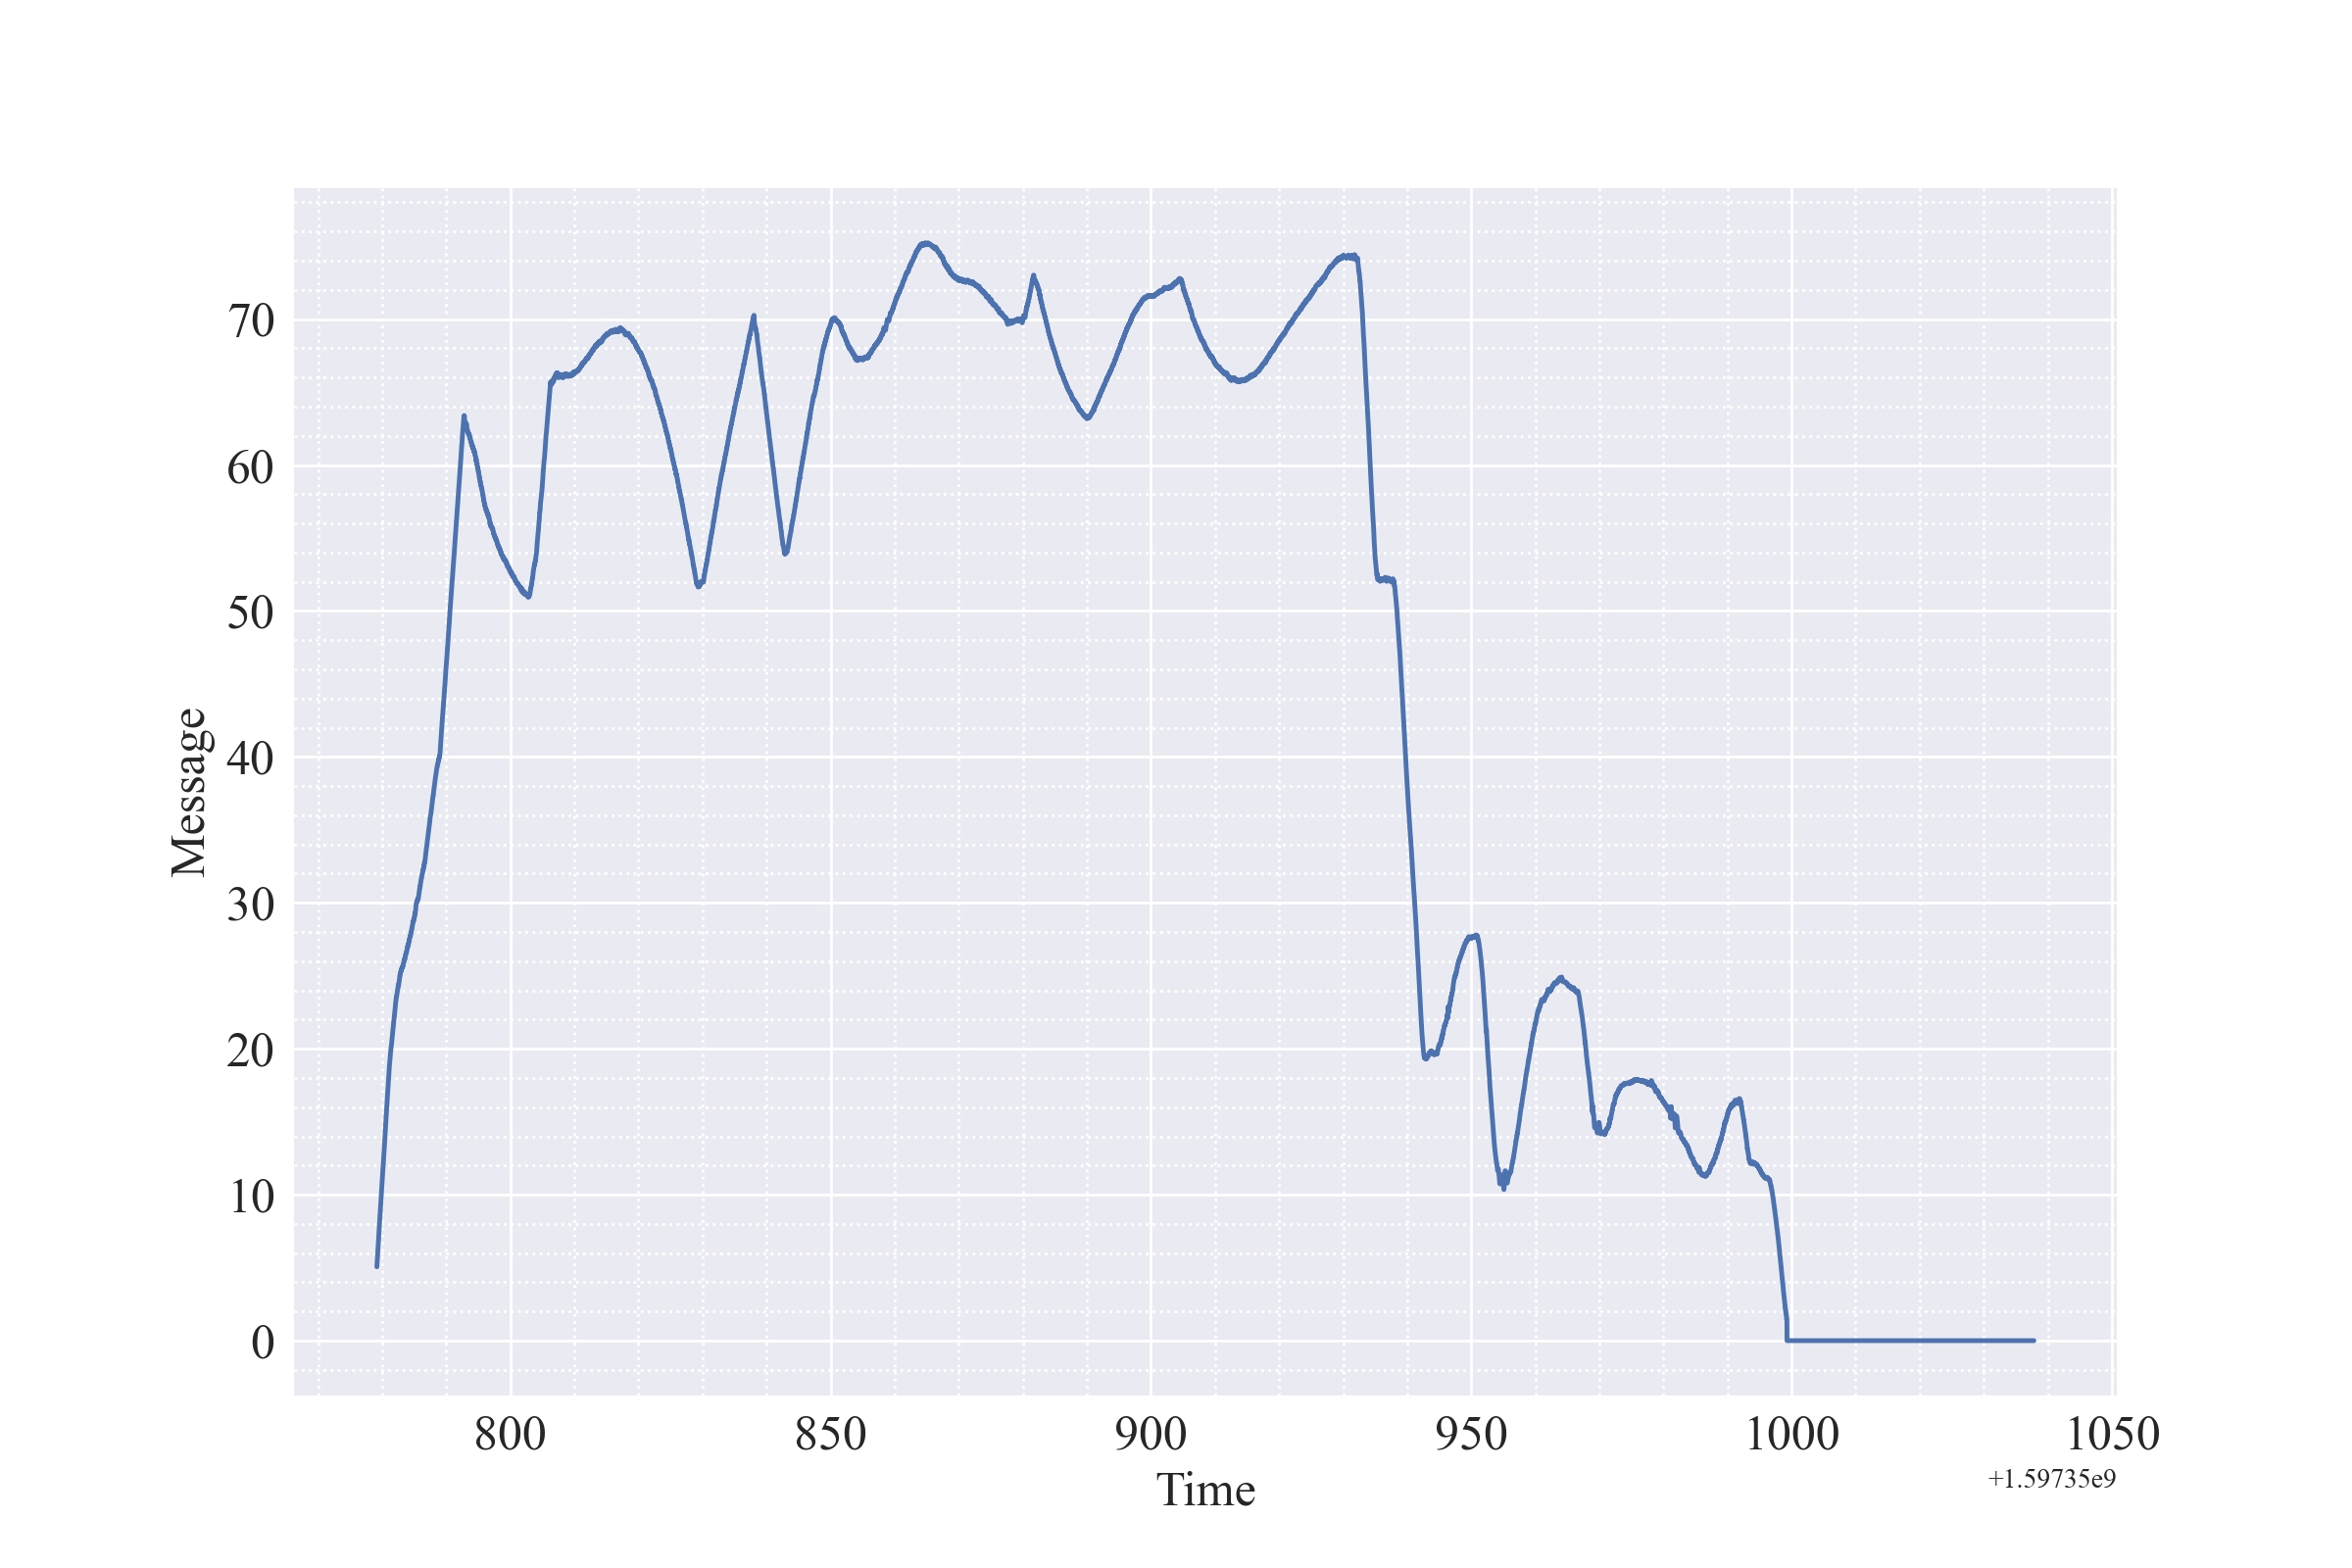

In [418]:
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(vel_t[iii:],vel_data[iii:])

In [364]:
starttime = vel_t[iii]
endtime=starttime+100
print(f'Starting at {starttime}, ending at {endtime}')

Starting at 1597350779.1810439, ending at 1597350879.1810439


In [365]:
dbcfile = '../examples/newToyotacode_experiment.dbc'

#identify starting time for all can_data, not just that thread
can_data_start_ndx = np.where(can_data['Time'] > starttime)[0][0]
can_data_end_ndx = np.where(can_data['Time'] > endtime)[0][0]

In [366]:
#%pip install ipympl
# If using JupyterLab
#%conda install nodejs
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib
#!jupyter lab build
#!jupyter labextension list

In [367]:
%matplotlib widget
def checksumExtract(msgid,can_data,_speed,db_file,start_ndx=0,end_ndx=None):
    msgstr='UNKNOWN_'+msgid
#     example_msg = db_file.get_message_by_name(msgstr)
#     print(example_msg.layout_string())
#     return
    print(msgstr)
    if end_ndx == None:
        result = DBC.convertData(msgstr,'CHECKSUM',can_data[start_ndx:],db_file)
    else:
        result = DBC.convertData(msgstr,'CHECKSUM',can_data[start_ndx:end_ndx],db_file)
    fig =plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    print(f'{result["Time"].values[0]} is the first time')
    #plt.plot(_439['Time'],_439['Message'],'r',_speed['Time'],_speed['Message'],'b',_speed_ch['Time'],_speed_ch['Message'],'g')
    ax.set_ylabel(msgid, fontsize=18)
    plt.plot(_speed['Time'],_speed['Message'],'b',
             result['Time'],result['Message'],'g')
    return result

In [368]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
checks = ['436','437','438','439','440','441','442','443','464']
for check in checks:
    checksumExtract(check,can_data,_speed,db_file,can_data_start_ndx,can_data_end_ndx)

UNKNOWN_436


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.1827419 is the first time
UNKNOWN_437


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.1827419 is the first time
UNKNOWN_438


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.183095 is the first time
UNKNOWN_439


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.18346 is the first time
UNKNOWN_440


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.184404 is the first time
UNKNOWN_441


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.1855118 is the first time
UNKNOWN_442


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.1855118 is the first time
UNKNOWN_443


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.185667 is the first time
UNKNOWN_464


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.184404 is the first time


In [369]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile)# Specify your dbc file
checks = ['562','565','578','579','580','581','582','583','584']
for check in checks:
    checksumExtract(check,can_data,_speed,db_file,can_data_start_ndx,can_data_end_ndx)

UNKNOWN_562


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.191243 is the first time
UNKNOWN_565


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.191606 is the first time
UNKNOWN_578


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.225411 is the first time
UNKNOWN_579


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.225978 is the first time
UNKNOWN_580


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.226377 is the first time
UNKNOWN_581


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.22732 is the first time
UNKNOWN_582


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.227527 is the first time
UNKNOWN_583


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.227847 is the first time
UNKNOWN_584


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350779.228868 is the first time


In [370]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
example_msg = db_file.get_message_by_name('GAS_PEDAL')
print(example_msg.layout_string())


                      Bit

         7   6   5   4   3   2   1   0
       +---+---+---+---+---+---+---+---+
     0 |   |   |   |   |<-x|   |   |   |
       +---+---+---+---+---+---+---+---+
                         +-- GAS_RELEASED2
       +---+---+---+---+---+---+---+---+
     1 |<------------------------------|
       +---+---+---+---+---+---+---+---+
     2 |------------------------------x|
       +---+---+---+---+---+---+---+---+
                                     +-- PART_0
       +---+---+---+---+---+---+---+---+
     3 |<------------------------------|
 B     +---+---+---+---+---+---+---+---+
 y   4 |------------------------------x|
 t     +---+---+---+---+---+---+---+---+
 e                                   +-- PART_1
       +---+---+---+---+---+---+---+---+
     5 |<-----------------------------x|
       +---+---+---+---+---+---+---+---+
                                     +-- PART_2
       +---+---+---+---+---+---+---+---+
     6 |<-----------------------------x|
       +-

In [371]:
# dbcfile = '../examples/newToyotacode_experiment.dbc'
# db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
# example_msg = db_file.get_message_by_name('STEERING_IPAS')
# print(example_msg.layout_string())

In [400]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
_rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_released = DBC.convertData('GAS_PEDAL','GAS_RELEASED2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_pedal = DBC.convertData('GAS_PEDAL','GAS_PEDAL',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_0 = DBC.convertData('GAS_PEDAL','PART_0',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_1 = DBC.convertData('GAS_PEDAL','PART_1',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_2 = DBC.convertData('GAS_PEDAL','PART_2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_N = DBC.convertData('GAS_PEDAL','PART_N',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
#_gas_4 = DBC.convertData('GAS_PEDAL','PART_4',can_data[can_data_start_ndx:can_data_end_ndx],db_file)


fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
plt.title('Gas Pedal Released')
plt.plot(_speed['Time'],_speed['Message'])
plt.plot(_gas_released['Time'],50*_gas_released['Message'])
plt.plot(_gas_pedal['Time'],100*_gas_pedal['Message'])
plt.plot(_gas_0['Time'],_gas_0['Message'])
plt.plot(_gas_1['Time'],_gas_1['Message'])
plt.plot(_gas_2['Time'],_gas_2['Message'])
plt.plot(_gas_N['Time'],_gas_N['Message'])
plt.plot(_rpm['Time'],0.01*_rpm['Message'])

# ,
#         _gas_4['Time'],50+10*_gas_4['Message'])
ax.legend(['Speed', 'Gas Pedal Released (x50)', 'Gas Pedal Percent', 'Gas0', 'Gas1', 'Gas2', 'GasN' ]) #, 'Gas4' ])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [374]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
_rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_released = DBC.convertData('GAS_PEDAL','GAS_RELEASED2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_pedal = DBC.convertData('GAS_PEDAL','GAS_PEDAL',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_part_0 = DBC.convertData('UNKNOWN_800','PART_0',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
# _gas_1 = DBC.convertData('GAS_PEDAL','PART_1',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
# _gas_2 = DBC.convertData('GAS_PEDAL','PART_2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_part_N = DBC.convertData('UNKNOWN_800','PART_N',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
#_gas_4 = DBC.convertData('GAS_PEDAL','PART_4',can_data[can_data_start_ndx:can_data_end_ndx],db_file)

print('I have little doubt that part_n is properly decoded, but not sure what it corresponds to.')

fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
plt.title('Gas Pedal Released')
plt.plot(_speed['Time'],_speed['Message'])
plt.plot(_gas_released['Time'],50*_gas_released['Message'])
plt.plot(_gas_pedal['Time'],100*_gas_pedal['Message'])
plt.plot(_rpm['Time'],0.01*_rpm['Message'])
plt.plot(_part_0['Time'],_part_0['Message'])
# plt.plot(_gas_1['Time'],_gas_1['Message'])
# plt.plot(_gas_2['Time'],_gas_2['Message'])
plt.plot(_part_N['Time'],_part_N['Message'])

# ,
#         _gas_4['Time'],50+10*_gas_4['Message'])
ax.legend(['Speed', 'Gas Pedal Released (x50)', 'RPM', 'Gas Pedal Percent', 'part0', 'partN' ]) #, 'Gas4' ])

I have little doubt that part_n is properly decoded, but not sure what it corresponds to.


/Users/sprinkle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [311]:
%matplotlib widget
db_file = cantools.db.load_file(dbcfile)# Specify your dbc file
_439 = DBC.convertData('UNKNOWN_439','CHECKSUM',can_data[:can_data_end_ndx],db_file)
_439_c = DBC.convertData('UNKNOWN_439','COUNTER',can_data[can_data_start_ndx:can_data_end_ndx],db_file)

_speed = DBC.convertData('SPEED','SPEED',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_speed_ch = DBC.convertData('SPEED','CHECKSUM',can_data[can_data_start_ndx:can_data_end_ndx],db_file)


fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
print(f'{_439["Time"].values[0]} is the first time')
#plt.plot(_439['Time'],_439['Message'],'r',_speed['Time'],_speed['Message'],'b',_speed_ch['Time'],_speed_ch['Message'],'g')
ax.set_ylabel('439', fontsize=18)
plt.plot(_speed['Time'],_speed['Message'],'b',
         _speed_ch['Time'],_speed_ch['Message'],'g')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1597350409.7632241 is the first time


In [376]:
dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile,strict=False)# Specify your dbc file
_rpm = DBC.convertData('ENGINE_SPD','RPM',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_released = DBC.convertData('GAS_PEDAL','GAS_RELEASED2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_gas_pedal = DBC.convertData('GAS_PEDAL','GAS_PEDAL',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_part_0 = DBC.convertData('GAS_SENSOR','INTERCEPTOR_GAS',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_part_1 = DBC.convertData('GAS_SENSOR','INTERCEPTOR_GAS2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
# _gas_2 = DBC.convertData('GAS_PEDAL','PART_2',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
# _part_N = DBC.convertData('UNKNOWN_800','PART_N',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
#_gas_4 = DBC.convertData('GAS_PEDAL','PART_4',can_data[can_data_start_ndx:can_data_end_ndx],db_file)

print('I have little doubt that part_n is properly decoded, but not sure what it corresponds to.')

fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
plt.title('Gas Pedal Released')
plt.plot(_speed['Time'],_speed['Message'])
plt.plot(_gas_released['Time'],50*_gas_released['Message'])
plt.plot(_gas_pedal['Time'],100*_gas_pedal['Message'])
plt.plot(_rpm['Time'],0.01*_rpm['Message'])
plt.plot(_part_0['Time'],_part_0['Message'])
plt.plot(_part_1['Time'],_part_1['Message'])
# plt.plot(_gas_2['Time'],_gas_2['Message'])
# plt.plot(_part_N['Time'],_part_N['Message'])

# ,
#         _gas_4['Time'],50+10*_gas_4['Message'])
ax.legend(['Speed', 'Gas Pedal Released (x50)', 'RPM', 'Gas Pedal Percent', 'part0', 'partN' ]) #, 'Gas4' ])

I have little doubt that part_n is properly decoded, but not sure what it corresponds to.


/Users/sprinkle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
decimalData_STEER_ANGLE = DBC.convertData('STEER_ANGLE_SENSOR',0, can_data, db_file)
decimalData_STEER_FRACTION = DBC.convertData('STEER_ANGLE_SENSOR',1, can_data, db_file)
decimalData_STEER_RATE = DBC.convertData('STEER_ANGLE_SENSOR',2, can_data, db_file)

In [51]:
Steering_Rate_Time = decimalData_STEER_RATE['Time'].values
Steering_Rate_Message = decimalData_STEER_RATE['Message'].values

In [52]:
Steering_Angle_Time = decimalData_STEER_ANGLE['Time'].values
Steering_Angle_Message = decimalData_STEER_ANGLE['Message'].values

In [53]:
from scipy import integrate

In [54]:
Steering_Rate_int = integrate.cumtrapz(Steering_Rate_Message, Steering_Rate_Time, initial=Steering_Angle_Message[0])

In [55]:
import matplotlib.pyplot as plt

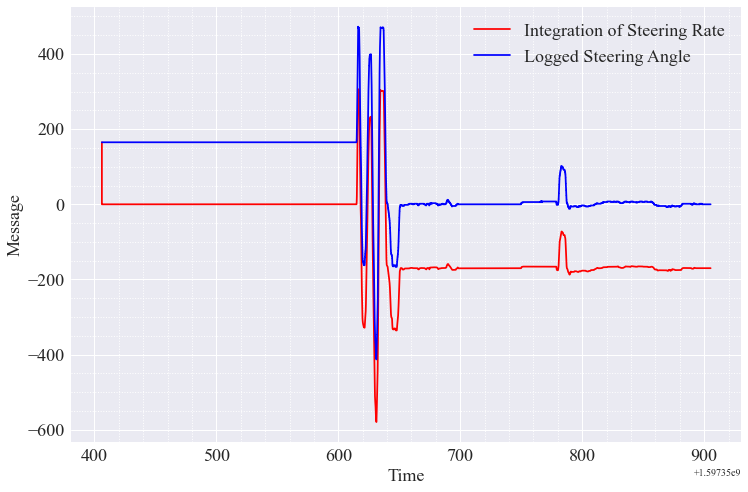

In [59]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
duration=100000
plt.plot(Steering_Rate_Time[0:duration], Steering_Rate_int[0:duration], 'r-', 
         Steering_Angle_Time[0:duration], Steering_Angle_Message[0:duration], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

In [60]:
Steering_Rate_int[100:200]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
Steering_Angle_Message[100:200]

array([165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165.])

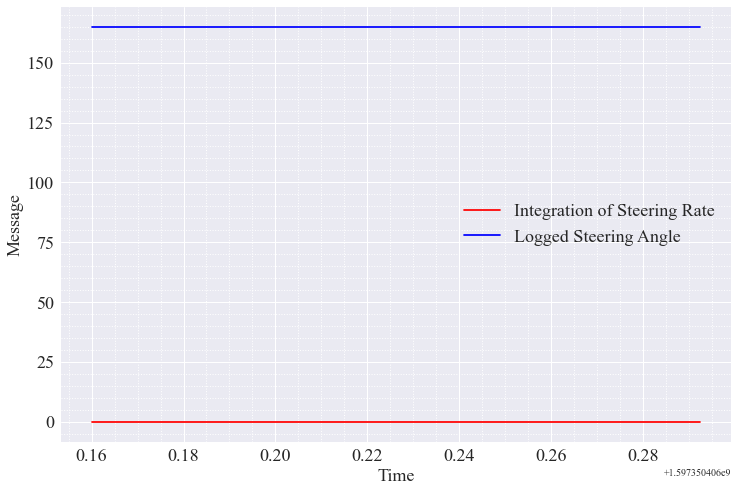

In [62]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[100:200], Steering_Rate_int[100:200], 'r-', Steering_Angle_Time[100:200], Steering_Angle_Message[100:200], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

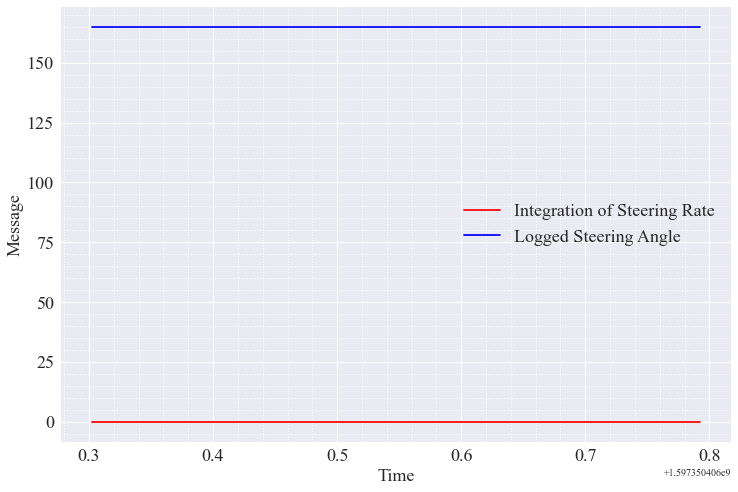

In [63]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[200:300], Steering_Rate_int[200:300], 'r-', Steering_Angle_Time[200:300], Steering_Angle_Message[200:300], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

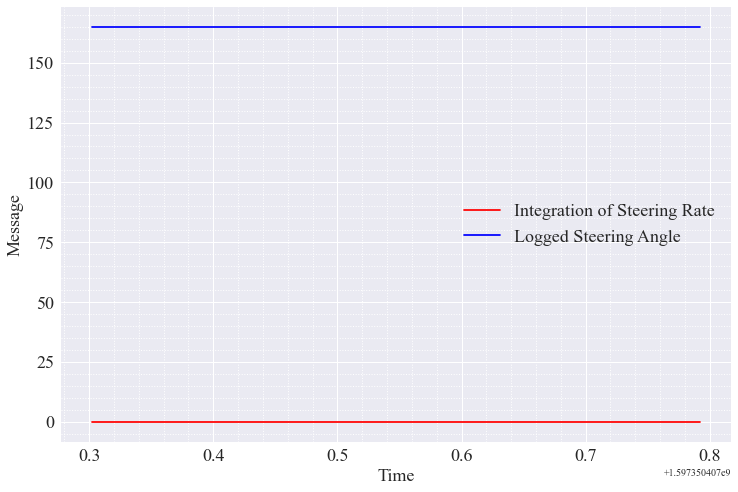

In [64]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[400:500], Steering_Rate_int[400:500], 'r-', Steering_Angle_Time[400:500], Steering_Angle_Message[400:500], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

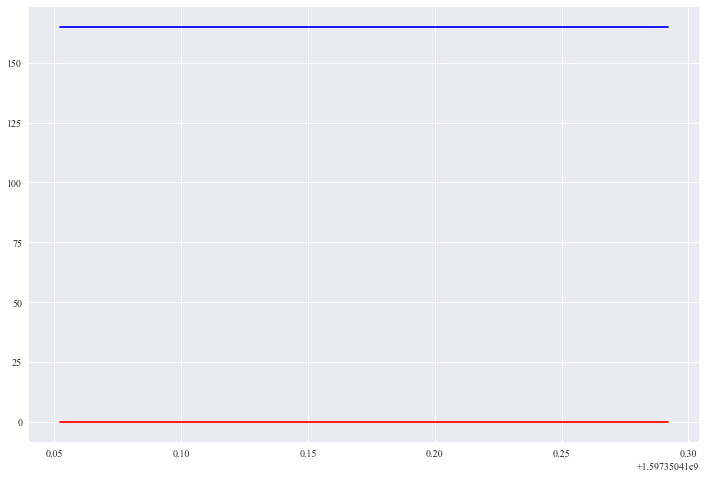

In [65]:
plt.plot(Steering_Rate_Time[950:1000], Steering_Rate_int[950:1000], 'r-', Steering_Angle_Time[950:1000], Steering_Angle_Message[950:1000], 'b-' )


## Experimental

(1501, 2)

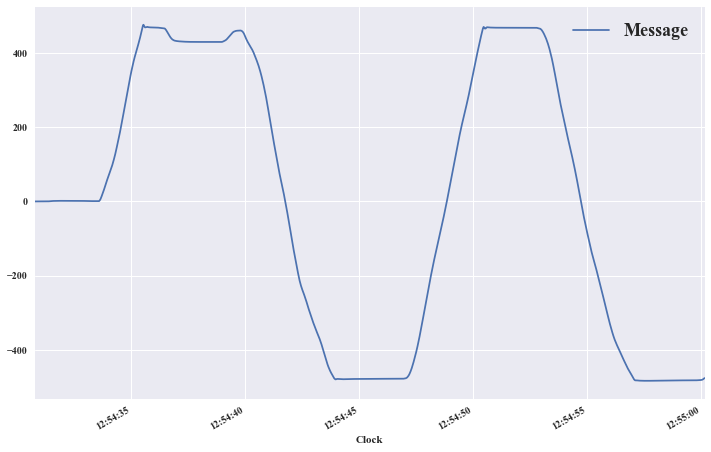

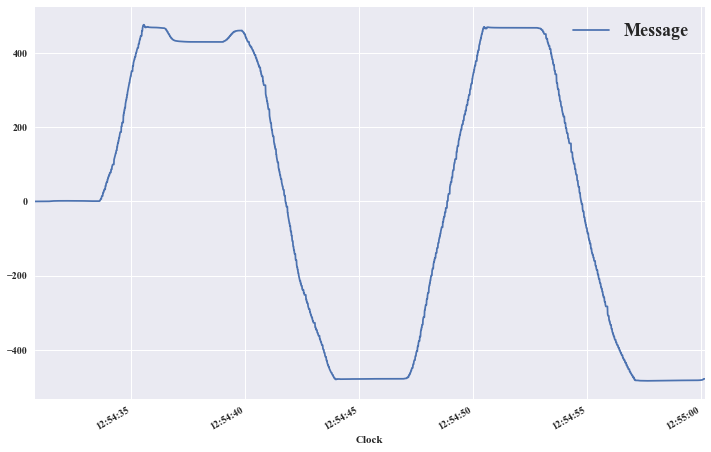

In [21]:
newdf = pd.DataFrame()
newdf['Time'] = decimalData_STEER_RATE['Time']
newdf['Message'] = Steering_Rate_int
newdf['ClockTime'] = newdf['Time'].apply(dateparse)
newdf
#days = pd.to_datetime(newdf['ClockTime'], unit='ns')
Time = pd.to_datetime(newdf['Time'], unit='s')

type(Time.dt.tz_localize('UTC'))
newdf['Clock'] = pd.DatetimeIndex(Time).tz_localize('UTC').tz_convert('US/Mountain')
newdf
newdf = newdf.set_index('Clock')
newdf
new2D = newdf.resample('10ms').ffill()
newdf  = newdf.drop(['Time'], axis = 1)
newdf.plot()
data_rate = 51.65
sampler = (1.0/data_rate)*1000.0
sampler = str(int(sampler)) + "ms"
new2D  = new2D.drop(['Time'], axis = 1)
new2D.plot()
newdf.shape